In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, argparse

### Are chiplets architecture always more sustainable than monolithic architecture?
We are sweeping total chip area from $50mm^2$ to $900mm^2$ in 7nm, and calculate corresponding manufacturing CFPs over from monolithic (1 die) to 9 chiplets configurations.

We then plot the results and compare the manufacturing CFPs of different configurations on every swept chip area to see if chiplet architecture do bring the lowest manufacturing CFP on every chip area.

In [7]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(parent_dir)
import utils, eco_chip_enhanced
defective_density_sequence, epa_sequence, gpa_sequence, carbon_intensity_sequence = utils.generate_probabilistic_sequences()
node = 7
sample_size = len(carbon_intensity_sequence)
dies = np.array(range(1,10))
areas = np.arange(50,900,50)
mcfp_to_return = dict()
mcfp_to_return['Area'] = areas

We follow similar way to generate mean manufacturing CFPs from all probabilistic samples on every chiplet configuration and every area. This is likely to take long time, more than 40mins. 

In [8]:
src = f'../../eco_chip_enhanced/arch_params/'
dest = f'chiplet_arch_params/'

utils.copy_design_operation_package(src=src, dest=dest)

for die in dies:
    key = f"die{die}"
    mfg_carbon_list = np.zeros(sample_size)
    mfg_carbon_mean_list = []
    mcfp = []
    for area in areas:
        utils.generate_node_arch(die, node, area, dest)      
        for i in range(sample_size):
            args = argparse.Namespace(
                design_dir = dest,
                chip_area = area,
                chip_power = '0', # we only model manufacturing CFP here, dont care about power
                node = node,
                defect_density = defective_density_sequence[str(node)][i],
                gpa = gpa_sequence[i], 
                epa = epa_sequence[str(node)][i],
                epa_pack = epa_sequence['65'][i],
                defect_density_pack = defective_density_sequence['65'][i],
                num_lifetime= None,
                tech_scaling_path= None,
                carbon_intensity = carbon_intensity_sequence[i]
            )
            design_carbon, mfg_carbon, ope_carbon, total_carbon = eco_chip_enhanced.eco_chip(args)
            mfg_carbon_list[i] = mfg_carbon

        mcfp.append(mfg_carbon_list.mean())
    mcfp_to_return[key] = mcfp

In [9]:
to_return = pd.DataFrame(mcfp_to_return)
to_return.to_csv(f"Area_Die_Sweep_{sample_size}_mfg.csv", index=False)

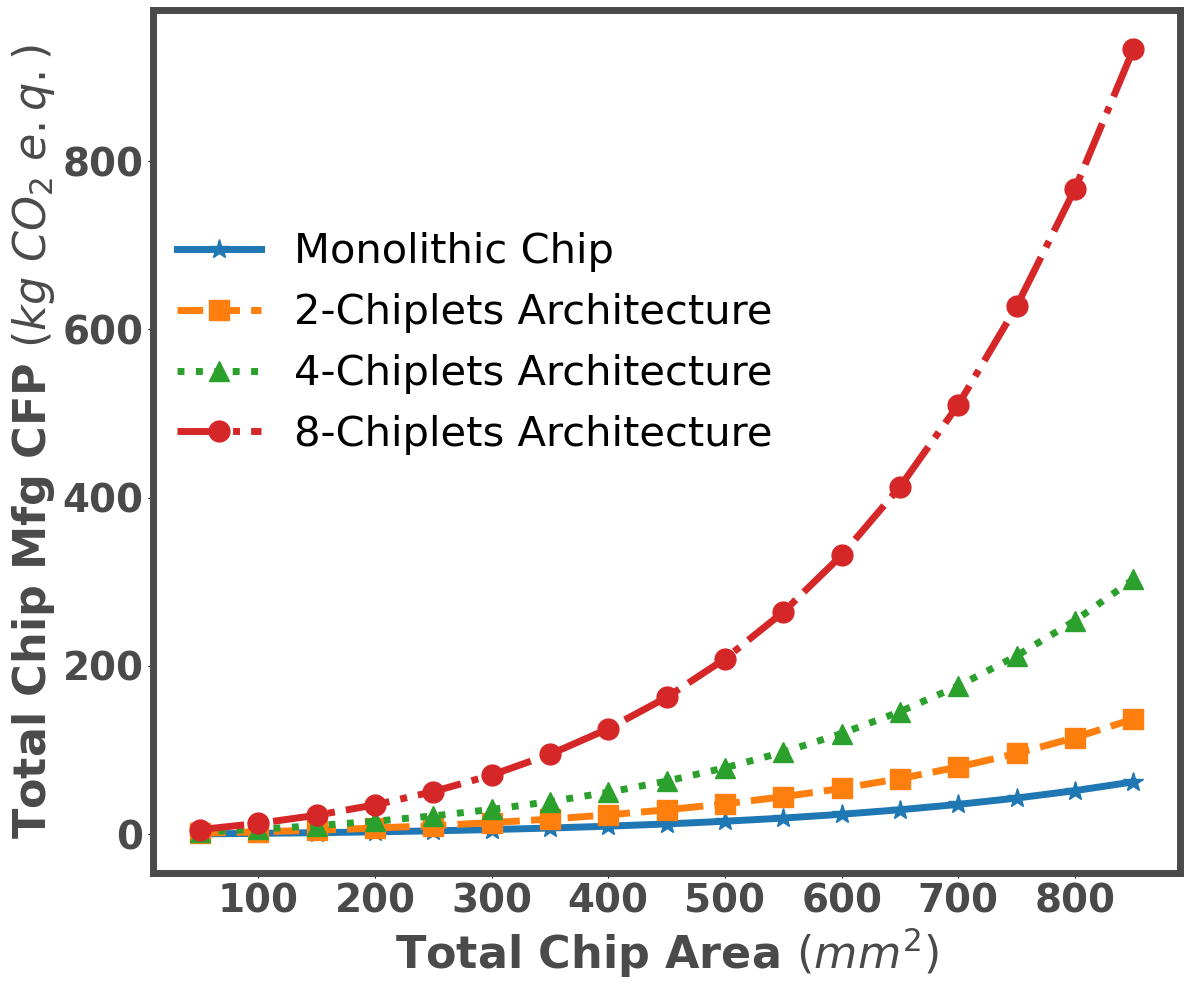

In [ ]:
sample = pd.read_csv(f"Area_Die_Sweep_{sample_size}_mfg.csv")


def normalize_row(row):
    return (row /row.min())  # Min-Max per row

def numerical_plot(is_normalize = False):

    # Plot for sample1
    dies = [1, 2, 4, 8]
    areas = np.arange(50,950,50)
    half_areas = int(areas.size / 1)
    markers = ['*', 's', '^', 'o']
    linetypes = ['-', '--', ':', '-.']
    linewidth = 5
    factor = 2
    markersize = 15 
    tick_font_size = 14  * factor
    legend_size = 15 * factor
    fig_width = 12
    fig_height = 10
    fig, axs = plt.subplots(figsize=(fig_width, fig_height))
    color0 = '#4a4a4a'  # Dark gray

    fontsize = 16 * factor

    if is_normalize:
        columns_to_normalize = sample.columns.difference(['Area'])
        sample[columns_to_normalize] = sample[columns_to_normalize].apply(normalize_row, axis=1)
    handles = []
    legend = []
    for i in range(len(dies)):
        x, = axs.plot(sample['Area'][:half_areas], sample[f'die{dies[i]}'][:half_areas], marker=markers[i], linestyle=linetypes[i], linewidth=linewidth, markersize=markersize)
        handles.append(x)
        if i == 0:
            legend.append('Monolithic Chip')
        else:    
            legend.append(f'{dies[i]}-Chiplets Architecture')

    axs.set_xlabel(r'Total Chip Area $(mm^2)$', fontweight='bold', fontsize=fontsize, color = color0)
    axs.set_ylabel(r'Total Chip Mfg CFP $(kg\ CO_2\ e.q.)$',  fontweight='bold', fontsize=fontsize, color=color0)
    fig.legend(handles=handles, labels=legend, loc='upper center',fontsize=legend_size, frameon=False, ncol=1, bbox_to_anchor=(0.4, 0.8))

    # axs.axvline(x=250, color='r', linestyle='--', linewidth=2)

    # axs.spines['right'].set_visible(False)
    # axs.spines['top'].set_visible(False)

    axs.spines['left'].set_color(color0)
    axs.spines['left'].set_linewidth(linewidth)

    axs.spines['right'].set_color(color0)
    axs.spines['right'].set_linewidth(linewidth)


    axs.spines['top'].set_color(color0)
    axs.spines['top'].set_linewidth(linewidth)

    axs.spines['bottom'].set_linewidth(linewidth)
    axs.spines['bottom'].set_color(color0)

    for tick in axs.get_xticklabels():
        tick.set_fontsize(tick_font_size)
        tick.set_fontweight('bold')
        tick.set_color(color0)

    for tick in axs.get_yticklabels():
        tick.set_fontsize(tick_font_size)
        tick.set_fontweight('bold')
        tick.set_color(color0)


    fig.tight_layout()
    return fig

fig = numerical_plot(is_normalize = False)
fig.savefig("chiplet_cfp_area_sweep.pdf", bbox_inches='tight', dpi=300)
